# Pokémon TCG Data Analysis

This notebook explores distributions of card rarities, HP distributions by stage, energy‐cost vs. damage relationships, and pack‐level summaries based on your Pokémon TCG CSV.


In [99]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colorsys
import networkx as nx

# render plots inline
%matplotlib inline


In [100]:
# Constants for graphs
TYPE_COLOURS = {
    "Colorless": "#D2D0CF",
    "Darkness": "#2E7077",
    "Dragon": "#948F31",
    "Fairy": "#D6457E",
    "Fighting": "#B16232",
    "Fire": "#D8223B",
    "Grass": "#19A648",
    "Lightning": "#FCD021",
    "Metal": "#9B9E8C",
    "Psychic": "#957DAB",
    "Water": "#05A8D9",
}


# Helper functions
def adjust_color(hex_color : str, factor : float) -> str:
    """
    Lightens / darkens a hex color
    
    Parameters
    ----------
        hex_color : str
            The original hex colour (#RRGGBB).
        factor : float
            The scaling factor to lighten / darken the colour.
            factor > 1 lightens, and < 1 darkens
            
    Returns
    -------
        new_colour : str
            The modified hex colour after changing brightness
    """
    rgb = mcolors.to_rgb(hex_color)
    hls = colorsys.rgb_to_hls(*rgb)
    # factor > 1 = lighten, factor < 1 = darken
    new_rgb = colorsys.hls_to_rgb(hls[0], max(0, min(1, hls[1] * factor)), hls[2])
    return mcolors.to_hex(new_rgb)

In [101]:
# load the data
df = pd.read_csv("data/full.csv")

# quick peek
df.head()


,number,name,rarity,stage,HP,type,weakness,retreat_cost,ultra_beast,generation,...,move1_name,move1_cost,move1_damage,move1_effect,move2_name,move2_cost,move2_damage,move2_effect,image,url
0,A1 001,Bulbasaur,◇,Basic,70.0,Grass,Fire,1.0,No,1,...,Vine Whip,🟢*️⃣,40,NaN,NaN,NaN,NaN,NaN,https://img.game8.co/3998332/91c4f79b2b3b42062...,https://game8.co/games/Pokemon-TCG-Pocket/arch...
1,A1 002,Ivysaur,◇◇,Stage 1,90.0,Grass,Fire,2.0,No,1,...,Razor Leaf,🟢*️⃣*️⃣,40,NaN,NaN,NaN,NaN,NaN,https://img.game8.co/4006820/34e0ae3e3a08bf458...,https://game8.co/games/Pokemon-TCG-Pocket/arch...
2,A1 003,Venusaur,◇◇◇,Stage 2,160.0,Grass,Fire,3.0,No,1,...,Mega Drain,🟢🟢*️⃣*️⃣,80,Heal 30 damage from this Pokemon.,NaN,NaN,NaN,NaN,https://img.game8.co/4003548/e62b9303f29d5360a...,https://game8.co/games/Pokemon-TCG-Pocket/arch...
3,A1 004,Venusaur ex,◇◇◇◇,Stage 2,190.0,Grass,Fire,3.0,No,1,...,Razor Leaf,🟢*️⃣*️⃣,60,NaN,Giant Bloom,🟢🟢*️⃣*️⃣,100,Heal 30 damage from this Pokemon.,https://img.game8.co/3995580/151d2c9455f838996...,https://game8.co/games/Pokemon-TCG-Pocket/arch...
4,A1 005,Caterpie,◇,Basic,50.0,Grass,Fire,1.0,No,1,...,Find a Friend,*️⃣,NaN,Put 1 random Grass Pokemon from your deck into...,NaN,NaN,NaN,NaN,https://img.game8.co/4004054/ac3d9d05b0255de5e...,https://game8.co/games/Pokemon-TCG-Pocket/arch...


## 1. Rarity Distribution

Count how many cards of each rarity (◇, ◇◇, ◇◇◇, ☆☆, etc.) there are


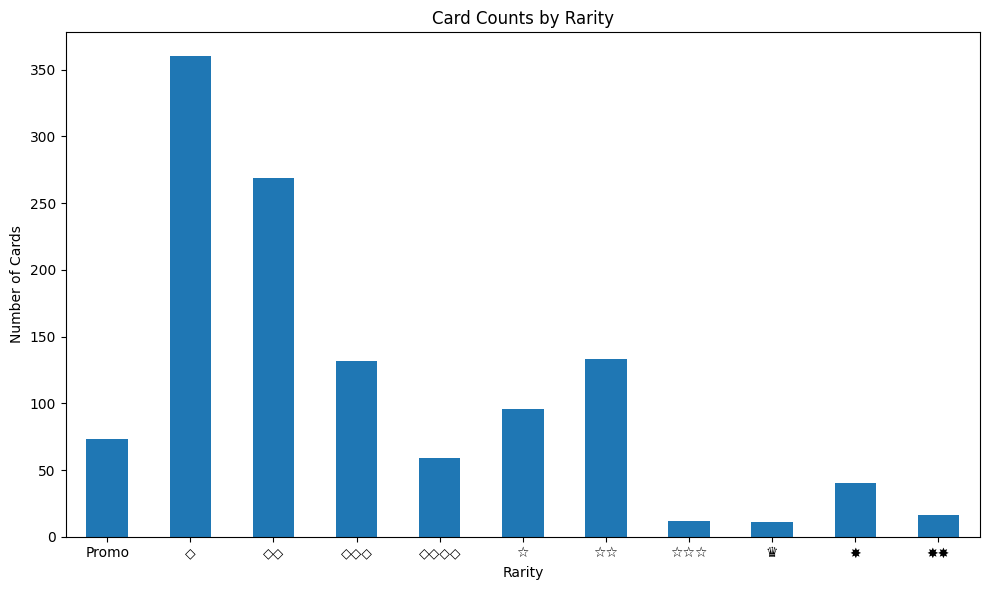

In [102]:
rarity_counts = df["rarity"].value_counts().sort_index()

plt.figure(figsize=(10,6))
rarity_counts.plot(kind="bar")
plt.title("Card Counts by Rarity")
plt.xlabel("Rarity")
plt.ylabel("Number of Cards")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 2. Type Distribution

Count how many cards of each type (Water, Fire, Metal, etc.) there are

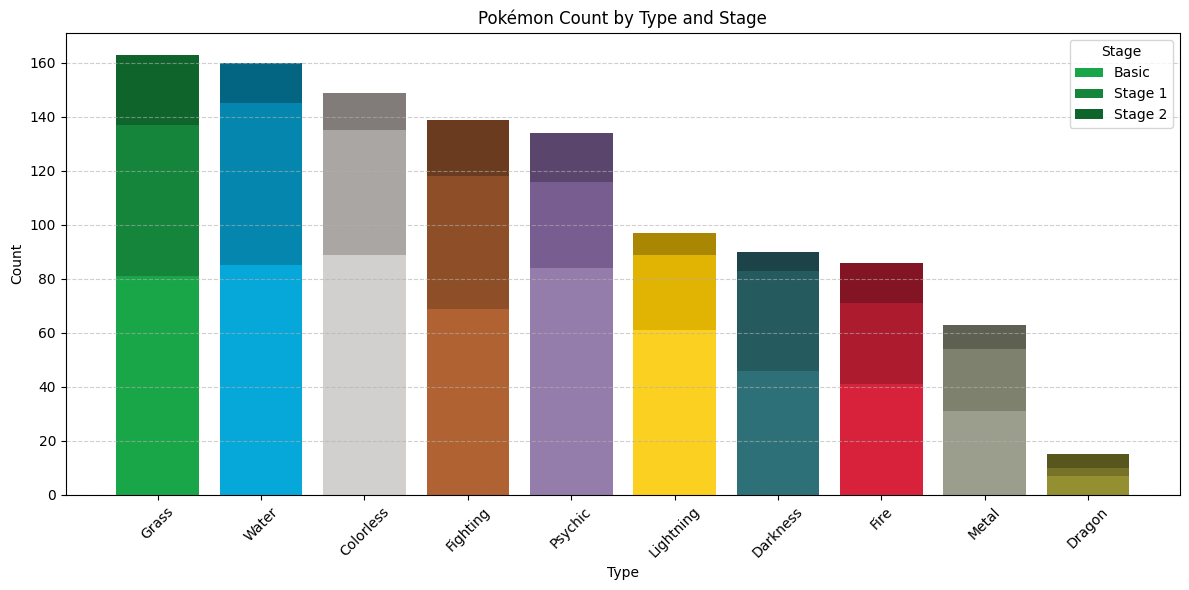

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

# Group and order
stages = ["Basic", "Stage 1", "Stage 2"]
grouped = df.groupby(["type", "stage"]).size().unstack(fill_value=0)
grouped = grouped[stages]
grouped = grouped.loc[grouped.sum(axis=1).sort_values(ascending=False).index]

# Plot manually using matplotlib
fig, ax = plt.subplots(figsize=(12, 6))

bottom = [0] * len(grouped)
x = range(len(grouped))
bar_width = 0.8

for stage, factor in zip(stages, [1.0, 0.8, 0.6]):
    values = grouped[stage].values
    colors = [adjust_color(TYPE_COLOURS.get(t, "#A0A0A0"), factor) for t in grouped.index]
    ax.bar(x, values, bottom=bottom, label=stage, color=colors, width=bar_width)
    bottom = [b + v for b, v in zip(bottom, values)]

# Labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(grouped.index, rotation=45)
ax.set_xlabel("Type")
ax.set_ylabel("Count")
ax.set_title("Pokémon Count by Type and Stage")
ax.legend(title="Stage")
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## 3. Move 1 Energy Cost vs. Damage

Scatter plot of “number of energy symbols” in move₁’s cost vs. its damage.


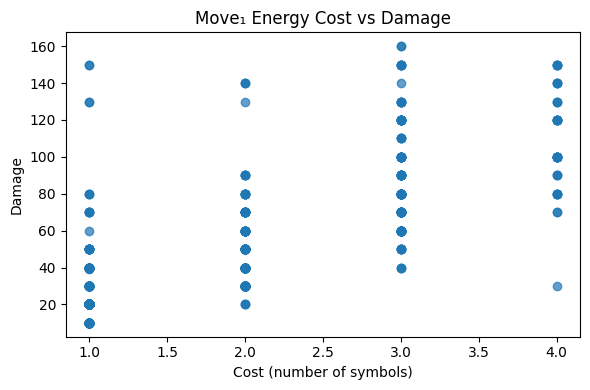

In [104]:
# count cost symbols (approximate by string length) and numeric damage
df["move1_cost"] = df["move1_cost"].str.replace("*️⃣", "*", regex=False)
df["move1_cost_count"] = df["move1_cost"].fillna("").str.len()
df["move1_damage"] = pd.to_numeric(df["move1_damage"], errors="coerce")

# drop rows without damage
scatter_df = df.dropna(subset=["move1_damage"])

plt.figure(figsize=(6,4))
plt.scatter(scatter_df["move1_cost_count"], scatter_df["move1_damage"], alpha=0.7)
plt.title("Move₁ Energy Cost vs Damage")
plt.xlabel("Cost (number of symbols)")
plt.ylabel("Damage")
plt.tight_layout()
plt.show()


## 4. Cards per Pack

Bar chart showing how many cards come from each pack.


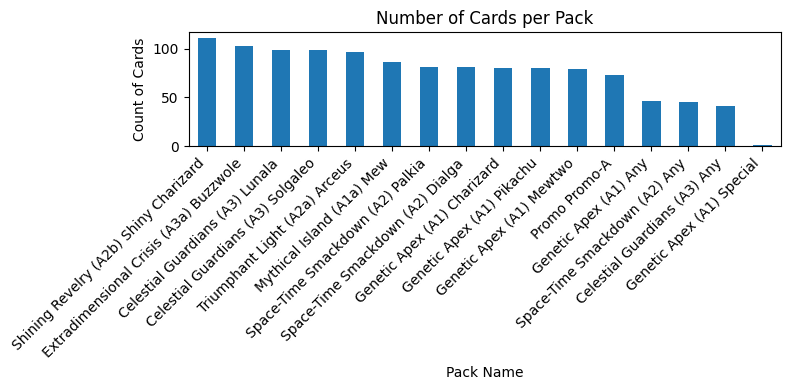

In [105]:
pack_counts = df["pack_name"].value_counts()

plt.figure(figsize=(8,4))
pack_counts.plot(kind="bar")
plt.title("Number of Cards per Pack")
plt.xlabel("Pack Name")
plt.ylabel("Count of Cards")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Type Weakness Graph

In [106]:
# Load all data
df = pd.read_csv("data/full.csv", usecols=["number", "weakness", "type"])

# Drop rows with missing values
df = df.dropna(subset=["weakness", "type"])

# Keep only types and weakness' if they are valid pokemon types
df = df[df["weakness"].isin(TYPE_COLOURS.keys()) & df["type"].isin(TYPE_COLOURS.keys())]

# Group and count occurrences
edge_counts = (
    df.groupby(["weakness", "type"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print(edge_counts)

     weakness       type  count
4        Fire      Grass    158
16  Lightning      Water    133
0    Darkness    Psychic    106
1    Fighting  Colorless    102
3    Fighting  Lightning     93
20      Water       Fire     79
7       Grass   Fighting     77
5        Fire      Metal     61
2    Fighting   Darkness     58
19    Psychic   Fighting     58
8   Lightning  Colorless     47
6       Grass   Darkness     30
18      Metal      Water     27
17      Metal    Psychic     25
11  Lightning       Fire      7
12  Lightning      Grass      5
10  Lightning   Fighting      4
13  Lightning  Lightning      4
15  Lightning    Psychic      3
9   Lightning   Darkness      2
14  Lightning      Metal      2


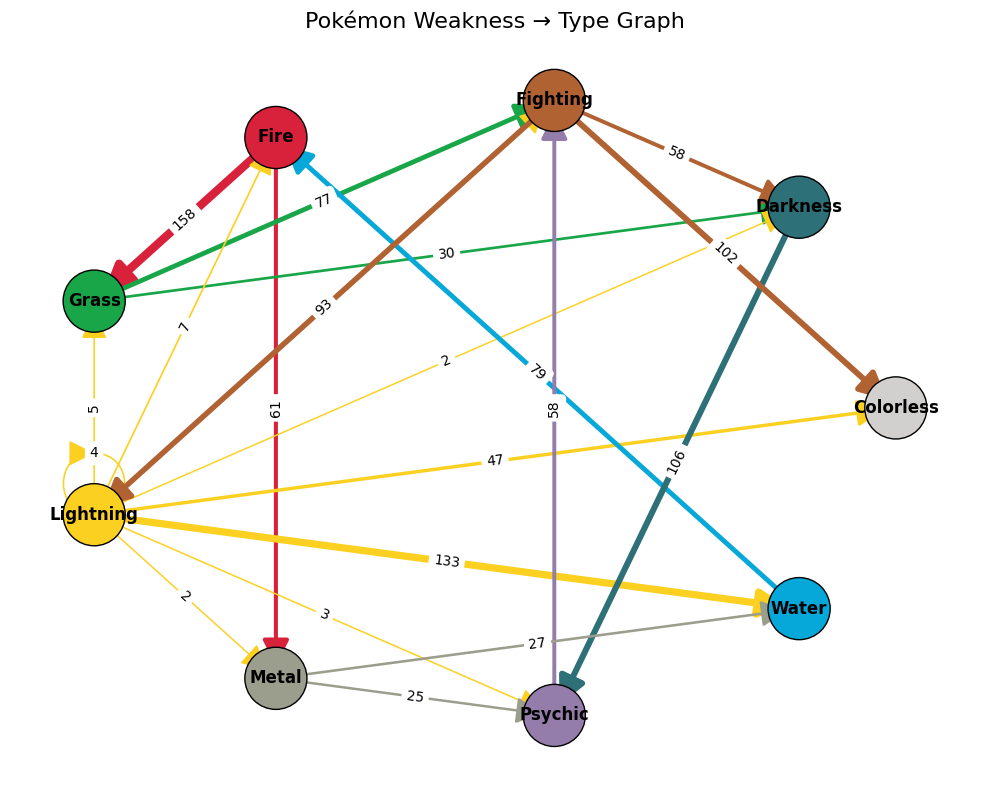

In [107]:
# Build directed graph
G = nx.DiGraph()
for _, row in edge_counts.iterrows():
    G.add_edge(row["weakness"], row["type"], weight=row["count"])

# Compute net flow score = outdegree - indegree
node_scores = {node: G.out_degree(node) - G.in_degree(node) for node in G.nodes()}
sorted_nodes = sorted(node_scores, key=node_scores.get, reverse=True)

# Regular n-gon arrangement
unique_types = sorted(set(edge_counts["weakness"]).union(set(edge_counts["type"])))
def regular_polygon_layout(nodes, radius=5):
    layout = {}
    n = len(nodes)
    for i, node in enumerate(nodes):
        angle = 2 * np.pi * i / n
        layout[node] = (radius * np.cos(angle), radius * np.sin(angle))
    return layout

# Custom layout: x by order, y by score
def score_layout(sorted_nodes, scores, x_spacing=2.5, y_scale=1.0):
    layout = {}
    for i, node in enumerate(sorted_nodes):
        layout[node] = (-i * x_spacing, scores[node] * y_scale)  # flipped x to have "strong" on left
    return layout

# pos = score_layout(sorted_nodes, node_scores)
pos = regular_polygon_layout(unique_types)

# Normalize weights for edge width
weights = [G[u][v]["weight"] for u, v in G.edges()]
max_weight = max(weights)
scaled_weights = [1 + 5 * (w / max_weight) for w in weights]

# Node and edge colors
node_colors = [TYPE_COLOURS.get(n, "#A0A0A0") for n in G.nodes()]
edge_colors = [TYPE_COLOURS.get(u, "#A0A0A0") for u, v in G.edges()]

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")
nx.draw_networkx_edges(
    G, pos, width=scaled_weights, edge_color=edge_colors, arrowstyle="-|>", arrowsize=40
)
edge_labels = {(u, v): G[u][v]["weight"] for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Pokémon Weakness → Type Graph", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()